 #### Finetuning the convnet: 
    Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

#### ConvNet as fixed feature extractor: 
    Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.


## Deely Understand about Traing, Validation , Test Phase

### Training Phase :
- Similar to the a lecture being taught in college. Concepts discussed in class and reasoning discussed by the professor to give you an idea about the problem domain. This usually comprises about 65% of the time you spend in college.

### Validation Phase :
- This is the tutorials you attend with the Teaching Assistant. You have learnt some concepts with the professor is training you during lecture hours. Here the TA usually gives you an assignment you are expected to solve and then discusses the solutions so that you can formalise your understanding of the concepts before you go to the final exam ( Testing Phase). This like tutorials would comprise about 20% of the total time.

### Testing Phase :
- This is the final exam. This objective here is to assess the concepts you learnt initially in the lectures(Training) and built upon in the tutorials(Validation). Here, ideally you are not provided with the answers beforehand :p. You submit your answers and an analysis of your performance is provided by various metrics. The testing phases tests the generalisation capabilities of the model(student in this case) beyond the training set.( Questions covered in lectures and tutorials).

## Other

   ### ConvNet as fixed feature extractor. 
        Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset. 
        
        In an AlexNet, this would compute a 4096-D vector for every image that contains the activations of the hidden layer immediately before the classifier. We call these features CNN codes. It is important for performance that these codes are ReLUd (i.e. thresholded at zero) if they were also thresholded during the training of the ConvNet on ImageNet (as is usually the case). Once you extract the 4096-D codes for all images, train a linear classifier (e.g. Linear SVM or Softmax classifier) for the new dataset.
    

   ### Fine-tuning the ConvNet. 
        The second strategy is to not only replace and retrain the classifier on top of the ConvNet on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. 
        
        This is motivated by the observation that the earlier features of a ConvNet contain more generic features (e.g. edge detectors or color blob detectors) that should be useful to many tasks, but later layers of the ConvNet becomes progressively more specific to the details of the classes contained in the original dataset. In case of ImageNet for example, which contains many dog breeds, a significant portion of the representational power of the ConvNet may be devoted to features that are specific to differentiating between dog breeds.
    

   ### Pretrained models.
        Since modern ConvNets take 2-3 weeks to train across multiple GPUs on ImageNet, it is common to see people release their final ConvNet checkpoints for the benefit of others who can use the networks for fine-tuning. For example, the Caffe library has a Model Zoo where people share their network weights.
        
        
### Transfer learning considerations
- The extent of how many layers are taken from the pretrained network, and whether to fine-tune them is dependent on various aspect:
    - The relation between original and new data - how much dothe tasks differ
    
    - The amount of new data to train on - should we be worriedabout overfitting our new training data?



In [16]:
from __future__ import print_function, division
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import time
import os 
import copy

#interactive mode
plt.ion() 

# Load Data

#### Train a model to classify ants and bees.

    - Training Images: 120 Imgs/class
    - Validation Images: 75 Imgs/class

In [1]:
# Data augmentation and normalization for training
# Just normalization for validtion
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data\hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NameError: name 'transforms' is not defined

# Visualize a few images

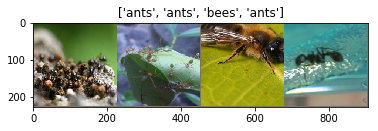

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model
- Scheduling the learning rate
- Saving the best model

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs= 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                #Set model to training mode
                model.train() 
            else:
                #Set model to evaluate mode
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #Zero the params gradients
                optimizer.zero_grad()
                
                ### Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,epoch_acc))
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    #Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualizing the model predictions
This is generic function to display predictions for a few images

In [5]:
def visualize_model(model, num_images= 1):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fipreg = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                # plt.subplot(行数, 列数, 何番目のプロットか)
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode= was_training)
                    return
        model.train(model=was_training)

# Finetuning the convnet
- Load a pretrained model and reset final fully connected layer

Here pretrained model is using AlexNet

![title](imageTutorial/alexnet.png)

In [ ]:
dset_classes_number = len(class_names)
model_ft = models.alexnet(pretrained=True) 
model_ft.fc = nn.Linear(4096, dset_classes_number)

if torch.cuda.is_available():
    model_ft = model_ft.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


# Train And Evaluate

In [ ]:
model_ft = train_model(model_ft, criterion, 
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
#Visualize model 
visualize_model(model_ft)


# ConvNet as fixed feature extractor

Freeze all the network except the final layer. Set 'requires_grad == False' to freeze the parameters so that the gradients 
are not computed in backward().


#### P/s: So I don't really think that it makes sense to allow such parameters. If you don't want to optimize some tensors, they're not parameters - they're fixed. You probably don't want to count them in. And if you really need to then

- optimizer.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [6]:
dset_classes_number = len(class_names)
model_conv = torchvision.models.alexnet(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv.classifier[6].parameters()), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [7]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4245 Acc: 0.8115
val Loss: 0.2722 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.2685 Acc: 0.8811
val Loss: 0.2669 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.2144 Acc: 0.9139
val Loss: 0.2424 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.2032 Acc: 0.9180
val Loss: 0.2806 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.1789 Acc: 0.9221
val Loss: 0.2646 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.2424 Acc: 0.9098
val Loss: 0.2475 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.1422 Acc: 0.9344
val Loss: 0.2592 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.1514 Acc: 0.9467
val Loss: 0.2532 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.1837 Acc: 0.9385
val Loss: 0.2516 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.1320 Acc: 0.9426
val Loss: 0.2493 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.1652 Acc: 0.9303
val Loss: 0.2507 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.1517 Acc: 0.9426
val Loss: 0.2501 Acc: 0.9346

Ep

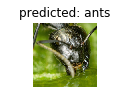

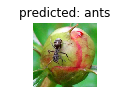

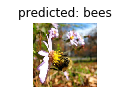

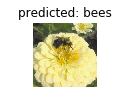

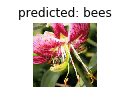

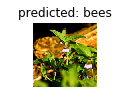

In [8]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# Predict Function

Prediction in progress


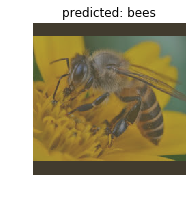

In [18]:
def predict_image(image_path):
    print("Prediction in progress")
    image = Image.open(image_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 224)
    transformation = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        input = Variable(image_tensor.cuda())

    # Turn the input into a Variable
    #input = Variable(image_tensor)
    #input = input.to(device)

    
    # Predict the class of the image
    output = model_conv(input)
    
    _, preds = torch.max(output, 1)
            
    ax = plt.subplot(121)
    ax.axis('off')
    ax.set_title('predicted: {}'.format(class_names[preds]))
    imshow(input.cpu().data[0])

#Save Model
#PATH1 = 'data/antbeeResNetModel.pt'
#PATH2 = 'data/antbeeResNetModel.pth.tar'

#torch.save(model_conv, PATH2)
#model = torch.load(PATH2)

image_path = 'data\\hymenoptera_data\\test\\download.jfif'
predict_image(image_path)